# **RecLEINN**: Recession Prediction by Time-Series Neural Network and Factor Analysis LEI

Here, we will be using our Artificial Leading Economic Index (A-LEI), which has a similar trend to Leading Economic Index (LEI) when compared to GDP.


A-LEI was composed from Factor Analysis in the previous Google Colab notebook. Then, we use Time-Series Neural Network to predict recession from A-LEI. Thus, we call the project **RecLEI-NN**.


# 1. GDP and Recession

**Gross Domestic Product** (GDP) is a key economic indicator that represents the total monetary value of all finished goods and services produced within a country's borders in a specific time period. GDP is often used as a measure of a country's economic performance and is a critical metric for assessing the overall health and size of an economy.

A **Recession** a significant decline in economic activity across the economy that lasts for an extended period, typically marked by a contraction in gross domestic product (GDP), employment, and other economic indicators.

In [49]:
from google.colab import drive
drive.mount('/content/drive')

import os
if os.getcwd() == '/content':
  os.chdir('drive/MyDrive/DataTeam1/Index1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd
from matplotlib import pyplot as plt

In [51]:
gdp = pd.read_csv("./datasets/USALORSGPNOSTSAM.csv")
gdp["Date"] = pd.to_datetime(gdp["DATE"])
gdp = gdp.set_index('Date')
gdp = gdp.drop('DATE', axis=1)
gdp = gdp.rename(columns={"USALORSGPNOSTSAM": "GDP"})

# gdp['nGDP'] = (gdp['GDP'] - gdp['GDP'].min()) / (gdp['GDP'].max() - gdp['GDP'].min())
gdp['nGDP'] = gdp['GDP'] - gdp['GDP'].mean()

gdp['GDP_diff'] = gdp['GDP'].diff()
gdp['GDP_diff'] = gdp['GDP_diff'].fillna(0)
gdp['nGDP_diff'] = (gdp['GDP_diff'] - gdp['GDP_diff'].min()) / (gdp['GDP_diff'].max() - gdp['GDP_diff'].min())

gdp.head(5)

,GDP,nGDP,GDP_diff,nGDP_diff
Date,,,,
1960-01-01,101.014185,1.034546,0.000000,0.738362
1960-02-01,101.024921,1.045282,0.010736,0.739846
1960-03-01,100.948665,0.969026,-0.076256,0.727819
1960-04-01,100.787739,0.808099,-0.160927,0.716112
1960-05-01,100.561229,0.581590,-0.226509,0.707045


In [52]:
rec = pd.read_csv("./datasets/USREC.csv")
rec["Date"] = pd.to_datetime(rec["DATE"])
rec = rec.set_index('Date')
rec = rec.drop('DATE', axis=1)
rec = rec.rename(columns={"USREC": "REC"})

rec.head(5)

,REC
Date,
1959-01-01,0
1959-02-01,0
1959-03-01,0
1959-04-01,0
1959-05-01,0


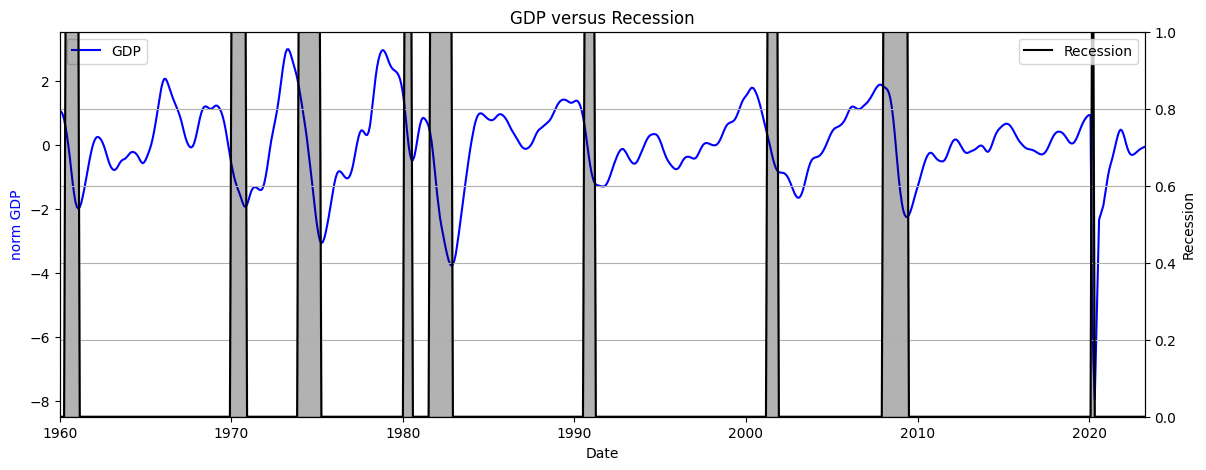

In [53]:
date_range = pd.date_range('1960-01-01', '2023-04-01')

fig, ax1 = plt.subplots(figsize = (14,5))

ax1.plot(gdp['nGDP'], color='b', label='GDP')
ax1.set_xlabel('Date')
ax1.set_ylabel('norm GDP', color='b')
ax1.set_xlim(94, 104)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(rec['REC'], color='black', label='Recession')
ax2.fill_between(rec.index, 0, rec['REC'], color='black', alpha=0.3, where=(rec['REC'] >= 0))
ax2.set_ylabel('Recession', color='black')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

plt.title('GDP versus Recession')
plt.xlim(date_range[0], date_range[-1])
plt.grid(True)
plt.show()

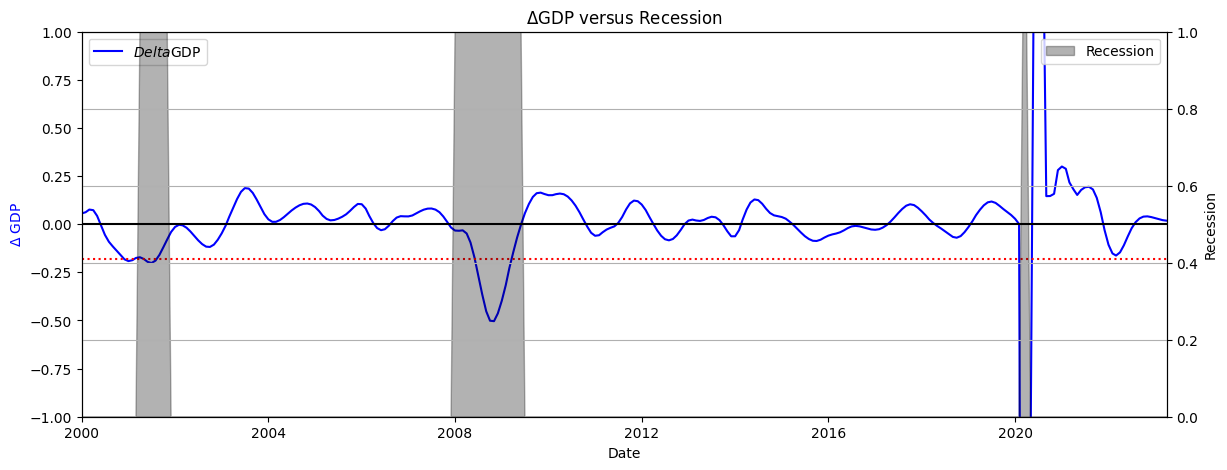

In [54]:
date_range = pd.date_range('2000-01-01', '2023-04-01')

fig, ax1 = plt.subplots(figsize = (14,5))

ax1.plot(gdp['GDP_diff'], color='b', label='$Delta$GDP', zorder=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('$\Delta$ GDP', color='b')
ax1.set_ylim(-1, 1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
# ax2.plot(rec['REC'], color='black', label='Recession', zorder=1)
ax2.fill_between(rec.index, 0, rec['REC'], color='black', alpha=0.3, where=(rec['REC'] >= 0), label="Recession")
ax2.set_ylabel('Recession', color='black')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

ax1.axhline(y=0, color='black', label='y=0.2')
ax1.axhline(y=-0.18, color='red', linestyle='dotted', label='y=-0.18')

plt.title('$\Delta$GDP versus Recession')
plt.xlim(date_range[0], date_range[-1])
plt.grid(True)
plt.show()

# 2. Factor Analysis

The purpose of factor analysis is to estimate a model that explains correlations between a set of observed variables by a set of fewer inobserved factors and weightings.

Factor Analysis combines the variables that are highly correlates to each other (in this case, variables refer to the components of LEI). The correlation is due to unmeasurable variable, so-called factor.

Here, we use eigenvalues method to determine the number of factors that will explain the correlation. In this method, we will use scree plot to plot between the number of factor and eigenvalues. Then, we will select the number that is just over 1. Communalities can be calculated by how much the factors can explain each variable. It is important to note that factor analysis only provide quantitative parameter of the data.

In [55]:
pip install factor_analyzer

In [56]:
!pip install pmdarima

In [57]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from datetime import timedelta
from datetime import datetime

import seaborn as sns
sns.set_palette("mako")
from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis

from tqdm import tqdm

plotsize = (15, 4)

In [58]:
all_index = pd.read_csv("./FactorAnalysis/indexes.csv")
all_index["DATE"] = pd.to_datetime(all_index["Date"])
all_index = all_index.set_index('DATE')
all_index = all_index.drop('Date', axis=1)
all_index.head(5)

,Standardized_index0,Standardized_index1,Standardized_index2,Standardized_index3,Standardized_index4,Standardized_index5,Standardized_index6,Standardized_index7,Standardized_index8,Standardized_index9
DATE,,,,,,,,,,
2000-01-01,2.094145,0.0,2.565682,-0.817285,0.612232,0.605348,0.938108,0.0,-0.059079,-0.756434
2000-02-01,2.036356,0.0,0.168551,-0.853812,0.409058,-0.003040,0.846411,0.0,-0.102960,-1.101270
2000-03-01,1.689620,0.0,-0.380400,-0.801131,0.110271,0.568365,0.738995,0.0,-0.013266,-1.301030
2000-04-01,1.862988,0.0,-0.489396,-0.791768,0.014659,0.654103,0.597521,0.0,0.086946,-1.457332
2000-05-01,1.986822,0.0,-0.764004,-0.817888,-0.451448,0.580693,0.456046,0.0,0.084957,-1.408627


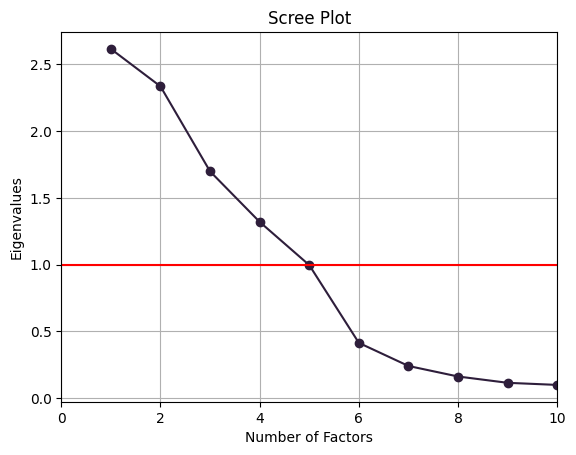

In [59]:
factor_analyzer = FactorAnalyzer()

factor_analyzer.fit(all_index)

eigenvalues = factor_analyzer.get_eigenvalues()[0]

plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.axhline(y=1, color='red', label='y=1')
plt.xlim(0, 10)
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [60]:
n_components = 4  # 4 factors are over 1
factor_analysis = FactorAnalysis(n_components=n_components, random_state=0)

factor_analysis.fit(all_index)

factor_loadings = factor_analysis.components_

factor_loading1 = -factor_loadings[0]
factor_loading2 = -factor_loadings[1]
factor_loading3 = -factor_loadings[2]
factor_loading4 = -factor_loadings[3]

for component_idx, component_loading in enumerate(factor_loadings):
    print(f"Factor Loadings for Component {component_idx + 1}: {component_loading}")

Factor Loadings for Component 1: [-6.81685482e-01 -5.43299986e-01  6.37615174e-04 -1.18874288e-01
 -4.48987703e-01 -2.27060029e-01 -5.13833917e-01  6.88098029e-02
  4.11596482e-01  2.85758063e-01]
Factor Loadings for Component 2: [-0.65054722  0.27300756 -0.04191846  0.69019189 -0.03872168  0.61620181
 -0.42956702  0.21275127 -0.04438666 -0.1568232 ]
Factor Loadings for Component 3: [ 0.43953184  0.20024866  0.06360288  0.01498257 -0.38157272  0.27066526
  0.12109685 -0.0574141   0.13437946 -0.68451722]
Factor Loadings for Component 4: [-0.11870352 -0.42482268 -0.01984546 -0.08858577  0.02030226 -0.01040498
  0.79544883  0.41893419 -0.01417054 -0.47203061]


In [61]:
LEI = factor_loading1[0]*all_index["Standardized_index1"] + factor_loading1[1] * all_index["Standardized_index2"] + factor_loading1[2] * all_index["Standardized_index3"] +\
factor_loading1[3] * all_index["Standardized_index4"] + factor_loading1[4] * all_index["Standardized_index5"] + factor_loading1[5] * all_index["Standardized_index6"] + \
factor_loading1[6] * all_index["Standardized_index7"] + factor_loading1[7] * all_index["Standardized_index8"] + factor_loading1[8] * all_index["Standardized_index9"] + \
factor_loading1[9] * all_index["Standardized_index0"]

lei = pd.DataFrame(LEI)
lei = lei.rename(columns={0: 'LEI'})

lei['nLEI'] = lei["LEI"] - lei["LEI"].mean()

weights = np.linspace(0, 1, 12)
lei['LEI_MA'] = lei['nLEI'].rolling(window=12).apply(lambda x: (x * weights).sum(), raw=True)
lei['LEI_MA'] = lei['LEI_MA'].fillna(0)

lei['LEI_diff'] = lei['LEI_MA'].diff()
lei['LEI_diff'] = lei['LEI_diff'].fillna(0)

lei.head(5)

,LEI,nLEI,LEI_MA,LEI_diff
DATE,,,,
2000-01-01,1.669028,1.604345,0.0,0.0
2000-02-01,0.210024,0.145342,0.0,0.0
2000-03-01,0.283523,0.218840,0.0,0.0
2000-04-01,0.227202,0.162520,0.0,0.0
2000-05-01,-0.097764,-0.162446,0.0,0.0


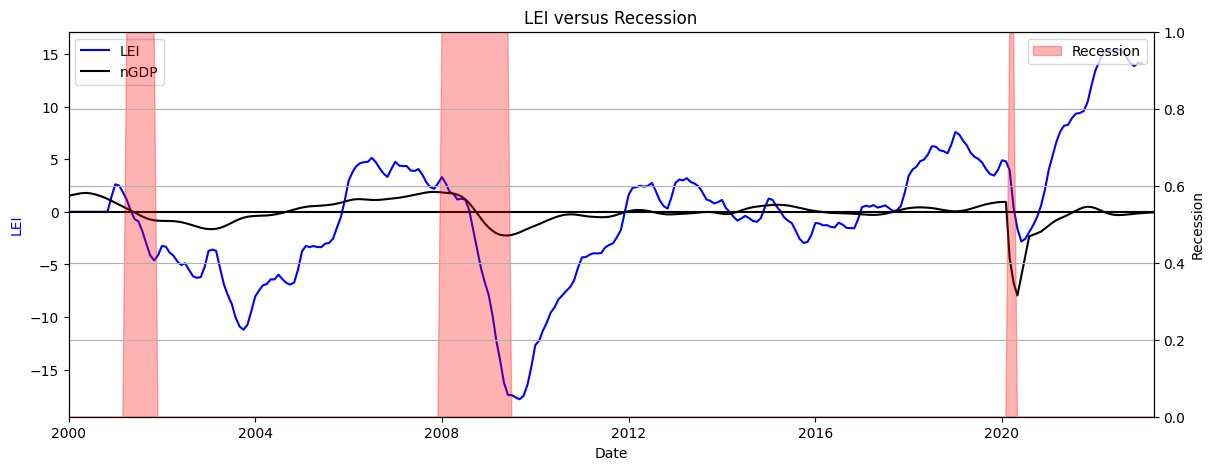

In [62]:
date_range = pd.date_range('2000-01-01', '2023-04-01')

fig, ax1 = plt.subplots(figsize = (14,5))

ax1.plot(lei['LEI_MA'], color='b', label='LEI', zorder=2)
ax1.plot(gdp['nGDP'], color='black', label='nGDP', zorder=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('LEI', color='b')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
# ax2.plot(rec['REC'], color='black', label='Recession', zorder=1)
ax2.fill_between(rec.index, 0, rec['REC'], color='red', alpha=0.3, where=(rec['REC'] >= 0), label="Recession")
ax2.set_ylabel('Recession', color='black')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

ax1.axhline(y=0, color='black', label='y=0.2')

plt.title('LEI versus Recession')
plt.xlim(date_range[0], date_range[-1])
plt.grid(True)
plt.show()

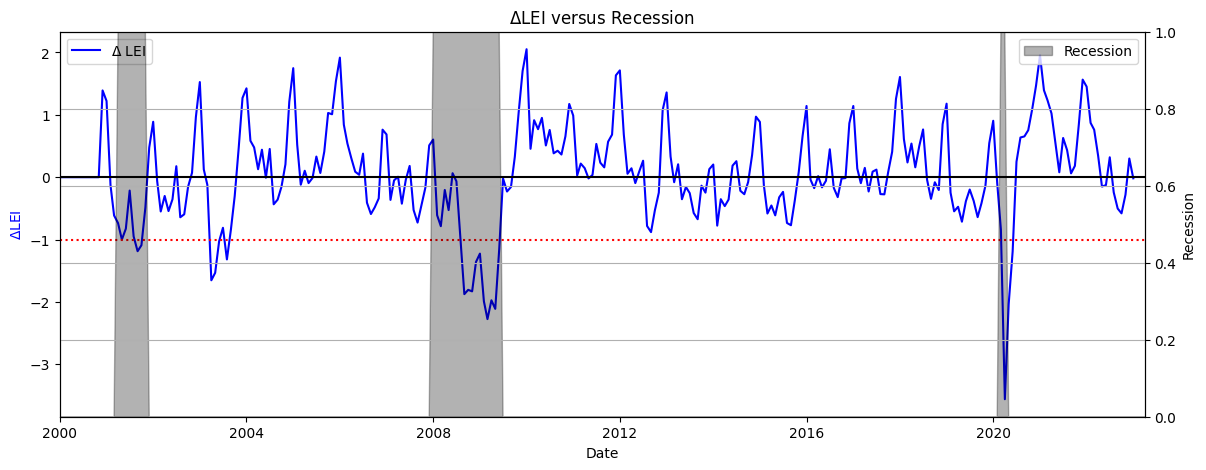

In [63]:
date_range = pd.date_range('2000-01-01', '2023-04-01')

fig, ax1 = plt.subplots(figsize = (14,5))

ax1.plot(lei['LEI_diff'], color='b', label='$\Delta$ LEI', zorder=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('$\Delta$LEI', color='b')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
# ax2.plot(rec['REC'], color='black', label='Recession', zorder=1)
ax2.fill_between(rec.index, 0, rec['REC'], color='black', alpha=0.3, where=(rec['REC'] >= 0), label="Recession")
ax2.set_ylabel('Recession', color='black')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

ax1.axhline(y=0, color='black', label='y=0.2')
ax1.axhline(y=-1, color='red', linestyle='dotted', label='y=-1')

plt.title('$\Delta$LEI versus Recession')
plt.xlim(date_range[0], date_range[-1])
plt.grid(True)
plt.show()

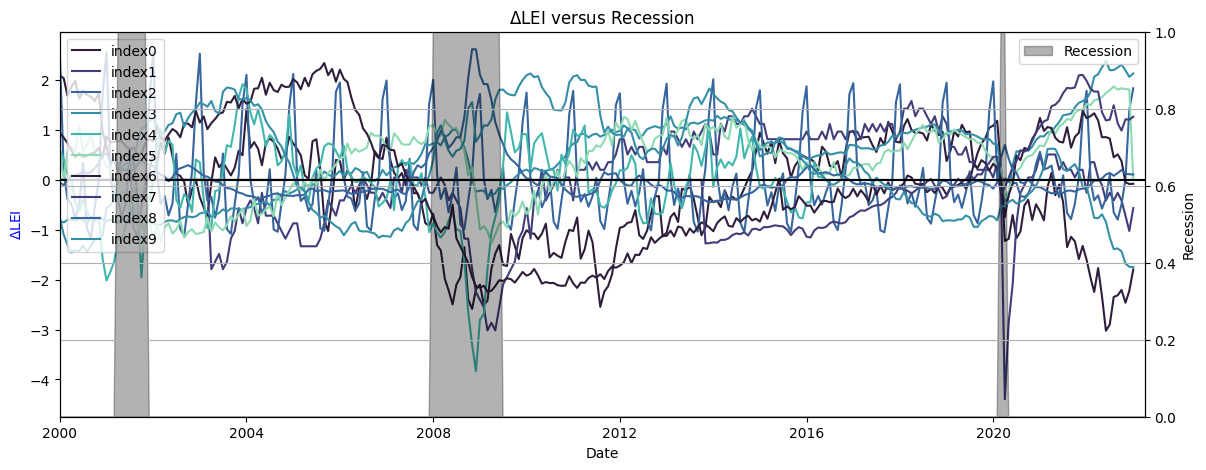

In [64]:
date_range = pd.date_range('2000-01-01', '2023-04-01')

fig, ax1 = plt.subplots(figsize = (14,5))

for i in range(10):
  ax1.plot(all_index['Standardized_index'+str(i)], label='index'+str(i), zorder=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('$\Delta$LEI', color='b')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.fill_between(rec.index, 0, rec['REC'], color='black', alpha=0.3, where=(rec['REC'] >= 0), label="Recession")
ax2.set_ylabel('Recession', color='black')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

ax1.axhline(y=0, color='black', label='y=0.2')

plt.title('$\Delta$LEI versus Recession')
plt.xlim(date_range[0], date_range[-1])
plt.grid(True)
plt.show()

# 3. Machine Learning Integration models

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

## 3.1 Time-series LEI-REC models: LEINet + RecNet model

In this section, two models are shown and explained. LEINet is used to predict LEI of following months based on previous months. RecNet is used to predict Recession of the next one month based on the LEI of previous months.

---

**LEINet** is a Convolutional Neural Network model with 1 hidden layer, 2 convolutional layers, and 1 hidden layer.
> Inputs: n months of LEI data (month x to x+n) <br>
> Outputs: n months of LEI data (month x+1 to x+n+1)

**RecNEt** is a Neural Network model with 2 hidden layers of 32x32 neurons.
> Inputs: n months of LEI data (month x to x+n) <br>
> Outputs: Recession probability of the next month (month x+n+1)

### 3.1.1 LEINet model

Mathematically, the model can be written as

$$ \left(\begin{matrix}LEI_{x+1}\\ LEI_{x+2}\\ \vdots \\ LEI_{x+n+1} \end{matrix} \right) = LEINet  \left(\begin{matrix}LEI_{x}\\ LEI_{x+1}\\ \vdots \\ LEI_{x+n} \end{matrix} \right)  $$

where $x$ is the starting month; $n$ is the number of correlated months (we use 12 months); $LEI$ is the constructued Leading Economic Indicator by Factor Analysis in section 2.

In [ ]:
month = 6
seed = 0
torch.manual_seed(0)

In [ ]:
lei_data = lei[(lei.index > '2000-01-01') & (lei.index < '2023-01-01')]
# gdp_data = gdp[(gdp.index > '1960-01-01') & (gdp.index < '2023-01-01')]

x_dataset = lei_data['LEI_MA'].values
# x_dataset = gdp_data['nGDP'].values
date = lei_data.index.values

x_dataset.shape, date.shape

((275,), (275,))

In [ ]:
x, y = [], []
for i in range(len(x_dataset) - month - 1):
  x.append(x_dataset[i:i + month])
  y.append(x_dataset[i + 1:i + month + 1])

x_dataset = np.array(x)
y_dataset = np.array(y)
date = date[month + 1:]

x_dataset.shape, y_dataset.shape, date.shape

((268, 6), (268, 6), (268,))

In [ ]:
class LEICNN(nn.Module):
    def __init__(self):
        super(LEICNN, self).__init__()
        self.fc1 = nn.Linear(6, 16)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 6)

    def forward(self, x):
        x = self.fc1(x)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

def count_parameters(model):
  return sum(p.numel() for p in model.parameters())

In [ ]:
dataset_x = torch.tensor(x_dataset.reshape(x_dataset.shape[0], x_dataset.shape[1]).astype(np.float32))
dataset_y = torch.tensor(y_dataset.reshape(y_dataset.shape[0], y_dataset.shape[1]).astype(np.float32))
dataset = TensorDataset(dataset_x, dataset_y)

train_size = 200
test_size = x_dataset.shape[0] - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

epochs = 500

model = LEICNN().cuda()
print(count_parameters(model))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

log_train_loss = []
log_test_loss = []

pbar = tqdm(range(epochs), dynamic_ncols=True, smoothing=0.2)

for epoch in pbar:
  model.train()
  train_loss_sum = 0.0

  for batch_x, batch_y in train_loader:

    batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
    outputs = model(batch_x).reshape(batch_y.shape)

    loss = criterion(outputs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_sum += loss.item()

    avg_train_loss = train_loss_sum / len(train_loader)

    model.eval()
    val_loss_sum = 0.0

    with torch.no_grad():
      for val_batch_x, val_batch_y in test_loader:
        val_batch_x, val_batch_y = val_batch_x.cuda(), val_batch_y.cuda()
        val_outputs = model(val_batch_x).reshape(val_batch_y.shape)
        val_loss = criterion(val_outputs, val_batch_y)
        val_loss_sum += val_loss.item()

    avg_val_loss = val_loss_sum / len(test_loader)

  log_train_loss.append(avg_train_loss)
  log_test_loss.append(avg_val_loss)

  pbar.set_description((f'Epoch {epoch}, Train loss: {avg_train_loss}, Test loss: {avg_val_loss}'))

271


Epoch 499, Train loss: 0.059032985381782054, Test loss: 0.05912184582224914: 100%|██████████| 500/500 [03:52<00:00,  2.15it/s]


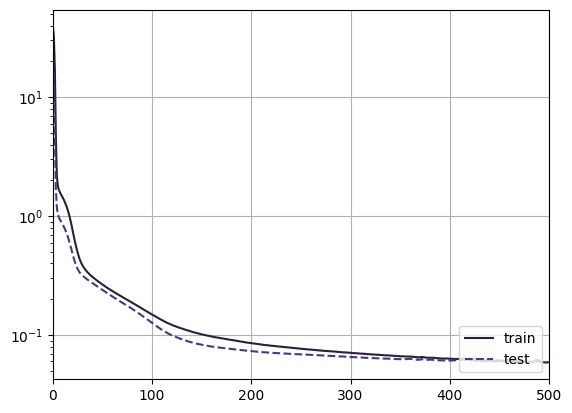

In [ ]:
plt.semilogy(log_train_loss, label = "train")
plt.semilogy(log_test_loss, "--", label = "test")
plt.grid(True)
plt.xlim(0, len(log_train_loss))
plt.legend(loc = "lower right")
plt.show()

In [ ]:
prediction_train = []
prediction_test = []
point = 0
for i in dataset_x:
  pred = model(i.reshape(1, 6).cuda())
  if point < train_size: prediction_train.append(pred[:, -1].detach().cpu().numpy())
  elif point >= train_size and point < train_size + test_size: prediction_test.append(pred[:, -1].detach().cpu().numpy())
  point += 1

prediction_next = []
input_i = dataset_x[-1]
j = 0
while j < 5:

  pred = model(input_i.reshape(1, 6).cuda())
  prediction_next.append(pred[:, -1].detach().cpu().numpy())
  input_i = torch.cat([input_i[:5], pred[:, -1].detach().cpu()], dim=0)
  j += 1

print(len(prediction_train), len(prediction_test), len(prediction_next))

200 68 5


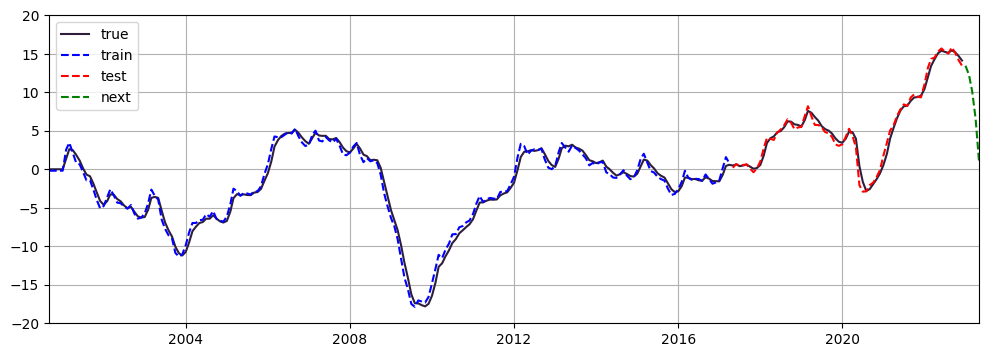

In [ ]:
date_new = pd.date_range(start="2023-01-01", end="2023-05-01", freq='MS')
plt.figure(figsize = (12,4))
plt.plot(date[:train_size + test_size], dataset_x[:, -1], label="true")
plt.plot(date[:train_size], prediction_train, "--", color = "blue", label="train")
plt.plot(date[train_size:train_size + test_size], prediction_test, "--", color = "red", label="test")
plt.plot(date_new, prediction_next, "--", color = "green", label="next")
plt.grid(True)
plt.xlim(date[0], date_new[-1])
plt.ylim(-20, 20)
plt.legend()
plt.show()

In [ ]:
# torch.save(model, "./models/LEINet")

### 3.1.2 RecNet model

Mathematically, the model can be written as

$$ P(Rec_{x+n+1}=1) = RecNet(LEI_x, LEI_{x+1}, \dots, LEI_{x+n}) $$

where $x$ is the starting month; $n$ is the number of correlated months (we use 12 months); $LEI$ is the constructued Leading Economic Indicator by Factor Analysis in section 2; and $P(Rec_i = 1)$ is the probability of recession ($Rec$) in i month.

In [ ]:
month = 12
seed = 0
torch.manual_seed(0)

In [ ]:
lei_data = lei[(lei.index > '2000-01-01') & (lei.index < '2023-01-01')]
rec_data = rec[(rec.index > '2000-01-01') & (rec.index < '2023-01-01')]
gdp_data = gdp[(gdp.index > '1960-01-01') & (gdp.index < '2023-01-01')]
# rec_data = rec[(rec.index > '1960-01-01') & (rec.index < '2023-01-01')]

x_dataset = lei_data['LEI_MA'].values
# x_dataset = gdp_data['nGDP'].values
y_dataset = rec_data['REC'].values
date = rec_data.index.values

x_dataset.shape, y_dataset.shape, date.shape

((275,), (275,), (275,))

In [ ]:
x = []
for i in range(len(x_dataset) - month):
  x.append(x_dataset[i:i + month])

x_dataset = np.array(x)
y_dataset = y_dataset[month:]
date = date[month:]

x_dataset = x_dataset[:-1]
y_dataset = y_dataset[1:]
date = date[1:]

x_dataset.shape, y_dataset.shape, date.shape

((262, 12), (262,), (262,))

#### a. simple

In [ ]:
from sklearn.model_selection import train_test_split

train_size = 200
test_size = x_dataset.shape[0] - train_size

train_x, test_x = train_test_split(np.arange(len(x_dataset)), test_size=test_size, random_state=seed, shuffle=False)

x_train, y_train = x_dataset[train_x], y_dataset[train_x]
x_test, y_test = x_dataset[test_x], y_dataset[test_x]

x_train = torch.tensor(x_train.astype(np.float32)).cuda()
y_train = torch.tensor(y_train.astype(np.float32)).reshape(train_size, 1).cuda()
x_test = torch.tensor(x_test.astype(np.float32)).cuda()
y_test = torch.tensor(y_test.astype(np.float32)).reshape(test_size, 1).cuda()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([200, 12]),
 torch.Size([200, 1]),
 torch.Size([62, 12]),
 torch.Size([62, 1]))

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters())

class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(month, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [ ]:
model = SimpleClassifier().cuda()

print(count_parameters(model))
print(model)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss = []
test_loss = []

num_epochs = 1000

for epoch in tqdm(range(num_epochs)):

    outputs = model(x_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(x_test)
        val_loss = criterion(val_outputs, y_test)

    train_loss.append(loss.detach().cpu().numpy())
    test_loss.append(val_loss.detach().cpu().numpy())

449
SimpleClassifier(
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 1000/1000 [00:02<00:00, 387.61it/s]


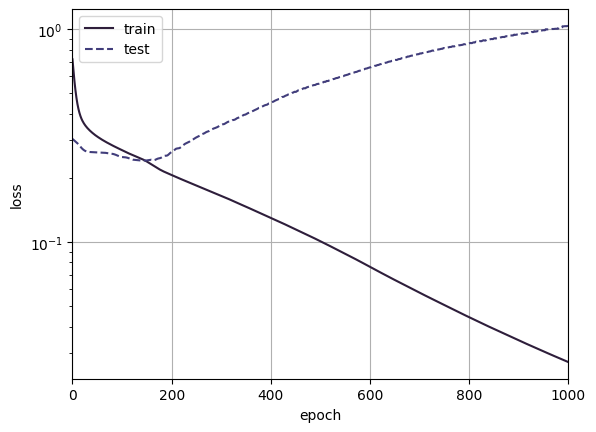

In [ ]:
plt.semilogy(train_loss, label = "train")
plt.semilogy(test_loss, '--', label="test")
plt.grid(True)
plt.xlim(0, len(train_loss))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

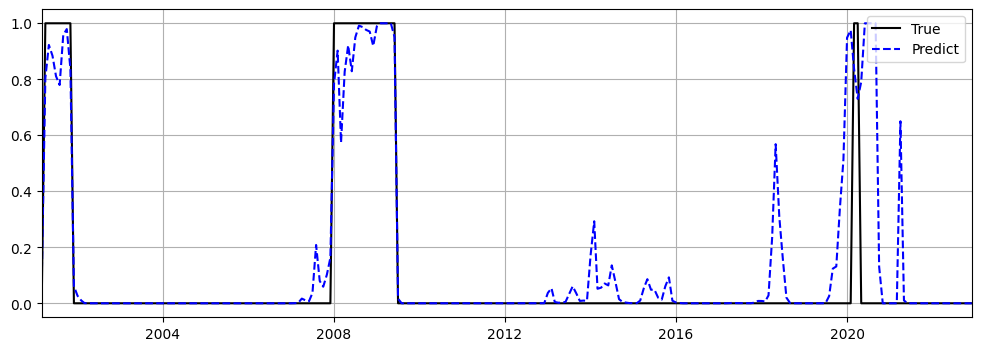

In [ ]:
predict_nn = torch.cat([outputs, val_outputs], dim=0).detach().cpu().numpy()

plt.figure(figsize = (12,4))
plt.plot(date, y_dataset, color = "black", label = "True")
plt.plot(date, predict_nn, "--", color = "blue", label = "Predict")
plt.grid(True)
plt.xlim(date[0], date[-1])
plt.legend(loc = "upper right")
plt.show()

#### b. complicated

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset_x = torch.tensor(x_dataset.astype(np.float32))
dataset_y = torch.tensor(y_dataset.reshape(y_dataset.shape[0],1).astype(np.float32))
dataset = TensorDataset(dataset_x, dataset_y)

train_size = 200
test_size = x_dataset.shape[0] - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

epochs = 1000

model = SimpleClassifier().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

log_train_loss = []
log_test_loss = []

pbar = tqdm(range(epochs), dynamic_ncols=True, smoothing=0.2)

for epoch in pbar:
  model.train()
  train_loss_sum = 0.0

  for batch_x, batch_y in train_loader:

    batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
    outputs = model(batch_x)
    loss = criterion(outputs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_sum += loss.item()

    avg_train_loss = train_loss_sum / len(train_loader)

    model.eval()
    val_loss_sum = 0.0

    with torch.no_grad():
      for val_batch_x, val_batch_y in test_loader:
        val_batch_x, val_batch_y = val_batch_x.cuda(), val_batch_y.cuda()
        val_outputs = model(val_batch_x)
        val_loss = criterion(val_outputs, val_batch_y)
        val_loss_sum += val_loss.item()

    avg_val_loss = val_loss_sum / len(test_loader)

  log_train_loss.append(avg_train_loss)
  log_test_loss.append(avg_val_loss)

  pbar.set_description((f'Epoch {epoch}, Train loss: {avg_train_loss}, Test loss: {avg_val_loss}'))

Epoch 999, Train loss: 0.0010623097798603013, Test loss: 1.8069845088257876: 100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]


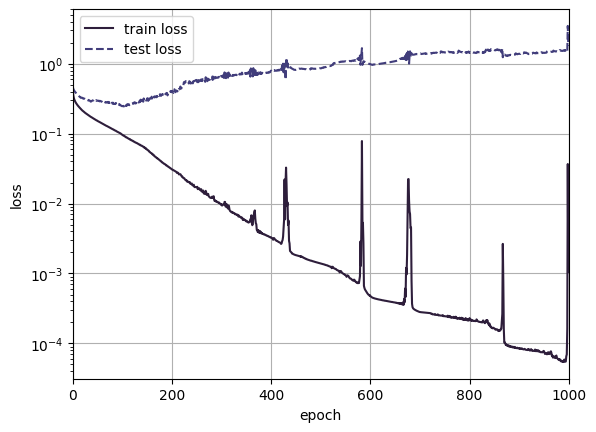

In [ ]:
plt.semilogy(log_train_loss, label = "train loss")
plt.semilogy(log_test_loss, '--', label="test loss")
plt.grid(True)
plt.xlim(0, len(log_train_loss))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
prediction_train = []
prediction_test = []
point = 0
for i in dataset_x:
  outputs = model(i.cuda())
  if point < 200: prediction_train.append(outputs.detach().cpu().numpy())
  else: prediction_test.append(outputs.detach().cpu().numpy())
  point += 1

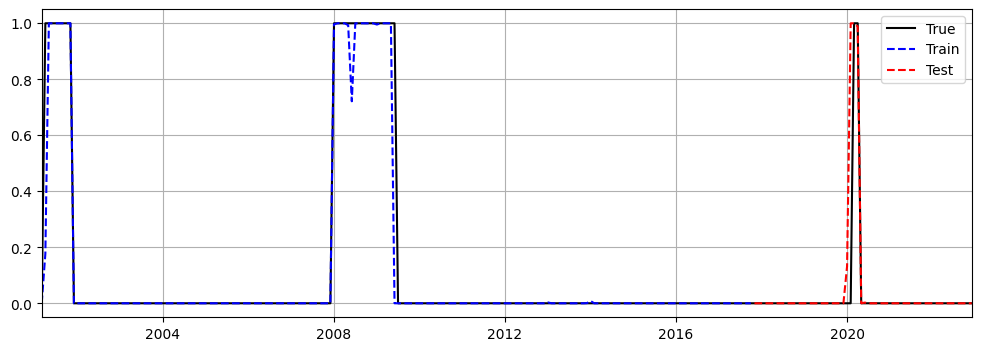

In [ ]:
plt.figure(figsize = (12,4))
plt.plot(date, y_dataset, color = "black", label = "True")
plt.plot(date[:200], prediction_train, "--", color = "blue", label = "Train")
plt.plot(date[200:], prediction_test, "--", color = "red", label = "Test")
plt.grid(True)
plt.xlim(date[0], date[-1])
plt.legend(loc = "upper right")
plt.show()

In [ ]:
torch.save(model, "./models/RecNet")

## 3.2 LEIcomp-Rec CNN models

In [66]:
all_index = all_index[(all_index.index > '2000-01-01') & (all_index.index < '2023-01-01')]

all_index["Date"] = all_index.index
all_index["Date"] = all_index["Date"].dt.to_period('M').dt.month

date_min = all_index['Date'].min()
date_max = all_index['Date'].max()
all_index['Date'] = (all_index['Date'] - date_min) / (date_max - date_min)
print(all_index.shape)
all_index.head(5)

(275, 11)


<ipython-input-66-823907167e18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_index["Date"] = all_index.index
<ipython-input-66-823907167e18>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_index["Date"] = all_index["Date"].dt.to_period('M').dt.month
<ipython-input-66-823907167e18>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

,Standardized_index0,Standardized_index1,Standardized_index2,Standardized_index3,Standardized_index4,Standardized_index5,Standardized_index6,Standardized_index7,Standardized_index8,Standardized_index9,Date
DATE,,,,,,,,,,,
2000-02-01,2.036356,0.0,0.168551,-0.853812,0.409058,-0.003040,0.846411,0.0,-0.102960,-1.101270,0.090909
2000-03-01,1.689620,0.0,-0.380400,-0.801131,0.110271,0.568365,0.738995,0.0,-0.013266,-1.301030,0.181818
2000-04-01,1.862988,0.0,-0.489396,-0.791768,0.014659,0.654103,0.597521,0.0,0.086946,-1.457332,0.272727
2000-05-01,1.986822,0.0,-0.764004,-0.817888,-0.451448,0.580693,0.456046,0.0,0.084957,-1.408627,0.363636
2000-06-01,1.631831,0.0,-0.517968,-0.774432,-0.630720,1.084795,0.532023,0.0,0.127702,-1.425708,0.454545


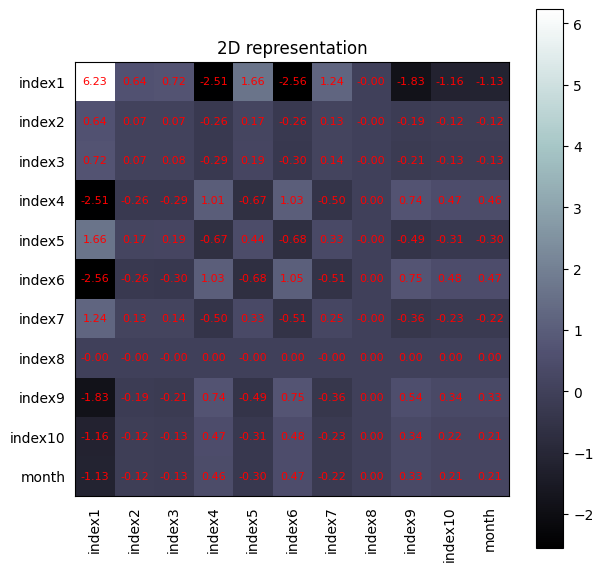

In [67]:
index_dataset = all_index.values.reshape((all_index.shape[0], all_index.shape[1], 1))
index_dataset2d = index_dataset.reshape((all_index.shape[0], all_index.shape[1], 1)) * index_dataset.reshape((all_index.shape[0], 1, all_index.shape[1]))

row_labels = ['index'+str(i) for i in range(1,11)] + ['month']

to_plot = index_dataset2d[100]

plt.figure(figsize = (7, 7))
plt.imshow(to_plot, cmap='bone', interpolation='nearest')
plt.xticks(np.arange(len(row_labels)), row_labels, rotation = 90)
plt.yticks(np.arange(len(row_labels)), row_labels)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
plt.title("2D representation")

for i in range(len(row_labels)):
    for j in range(len(row_labels)):
        plt.text(j, i, f'{to_plot[i, j]:.2f}', ha='center', va='center', color='red', fontsize=8)

plt.colorbar()
plt.show()

In [72]:
x_dataset = index_dataset2d.copy()

rec_data = rec[(rec.index > '2000-01-01') & (rec.index < '2023-01-01')]
y_dataset = rec_data['REC'].values

dataset_x = torch.tensor(x_dataset.astype(np.float32))
dataset_y = torch.tensor(y_dataset.astype(np.float32))

print(dataset_x.shape, dataset_y.shape)

dataset = TensorDataset(dataset_x, dataset_y)

torch.Size([275, 11, 11]) torch.Size([275])


In [135]:
train_size = 200
test_size = x_dataset.shape[0] - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_s = 10
row, col = 11, 11
train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False)

In [136]:
class LEICompREINet(nn.Module):
    def __init__(self):
        super(LEICompREINet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=11, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(9, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

def count_parameters(model):
  return sum(p.numel() for p in model.parameters())

In [148]:
epochs = 500

model = LEICompREINet().cuda()
print(count_parameters(model))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

log_train_loss = []
log_test_loss = []

pbar = tqdm(range(epochs), dynamic_ncols=True, smoothing=0.2)

for epoch in pbar:
  model.train()
  train_loss_sum = 0.0

  for batch_x, batch_y in train_loader:
    batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
    batch_x = batch_x.reshape(batch_s, 1, row, col)
    outputs = model(batch_x).reshape(-1)
    loss = criterion(outputs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_sum += loss.item()

    avg_train_loss = train_loss_sum / len(train_loader)

    model.eval()
    val_loss_sum = 0.0

    with torch.no_grad():
      for val_batch_x, val_batch_y in test_loader:
        val_batch_x, val_batch_y = val_batch_x.cuda(), val_batch_y.cuda()
        val_batch_x = val_batch_x.reshape(val_batch_x.shape[0], 1, row, col)
        val_outputs = model(val_batch_x).reshape(-1)
        val_loss = criterion(val_outputs, val_batch_y)
        val_loss_sum += val_loss.item()

    avg_val_loss = val_loss_sum / len(test_loader)

  log_train_loss.append(avg_train_loss)
  log_test_loss.append(avg_val_loss)

  pbar.set_description((f'Epoch {epoch}, Train loss: {avg_train_loss}, Test loss: {avg_val_loss}'))

1059


Epoch 499, Train loss: 3.0662199238441593e-06, Test loss: 0.22324554205216085: 100%|██████████| 500/500 [01:18<00:00,  6.35it/s]


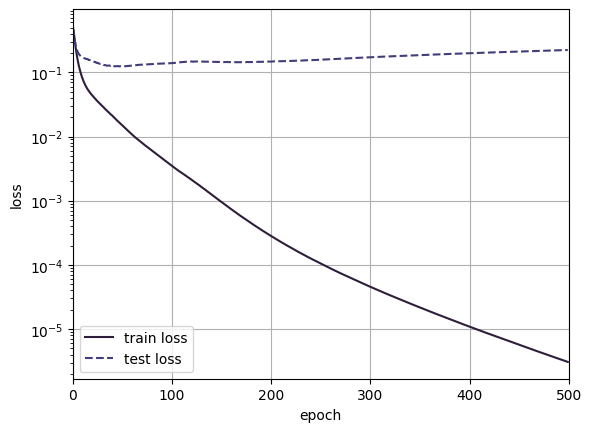

In [149]:
plt.semilogy(log_train_loss, label = "train loss")
plt.semilogy(log_test_loss, '--', label="test loss")
plt.grid(True)
plt.xlim(0, len(log_train_loss))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [159]:
prediction_train = []
prediction_test = []
point = 0
for i in dataset_x:
  i = i.reshape(1, row, col)
  outputs = model(i.cuda()).reshape(-1)
  if point < 200: prediction_train.append(outputs.detach().cpu().numpy())
  else: prediction_test.append(outputs.detach().cpu().numpy())
  point += 1

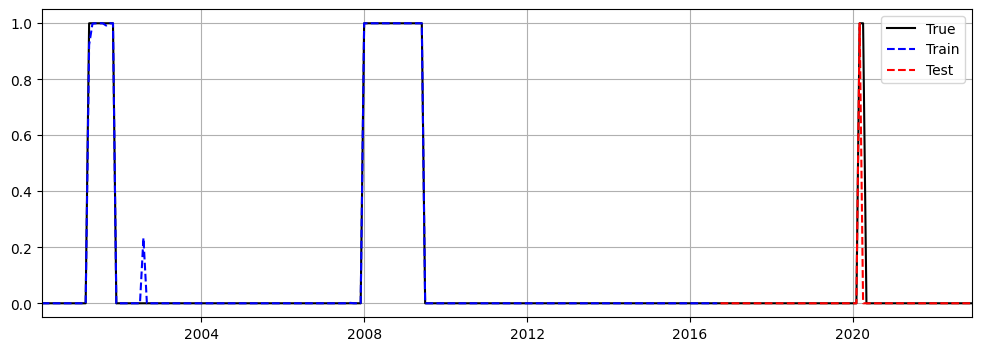

In [160]:
date = rec_data.index.values

plt.figure(figsize = (12,4))
plt.plot(date, y_dataset.reshape(-1), color = "black", label = "True")
plt.plot(date[:200], prediction_train, "--", color = "blue", label = "Train")
plt.plot(date[200:], prediction_test, "--", color = "red", label = "Test")
plt.grid(True)
plt.xlim(date[0], date[-1])
plt.legend(loc = "upper right")
plt.show()

# Remarks

Neural network models, including LEINet, RectNet, and LEICompRec, have demonstrated their strong performance in both self-prediction and classification tasks. The models exhibited notable learning capabilities during the training period from 2000 to 2016, showcasing their ability to capture and generalize patterns within the data. As a result, these models were able to make accurate predictions during the subsequent test period from 2017 to 2020.

In [161]:
print("Hello World")

Hello World
